<a href="https://colab.research.google.com/github/AAI-520/AAI_520_Gen_Chatbot_Final_Project/blob/svaddi/AAI_520_Gen_Chatbot_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

**About the project:**

In today's digital age, businesses face a growing demand for efficient and responsive customer support services. Chatbots have emerged as a valuable solution to address this need by providing real-time assistance to customers and users. This document outlines the business understanding behind building a chatbot for conversational support.

**Author(s):**

Jamileh Jahangiry

Kobe Mensah

Shas Vaddi


### **I. Business Understanding**

Business Goals
The primary goals of developing a chatbot for conversational support are:

**Enhanced Customer Experience**

Improve the overall customer experience by offering timely and helpful responses to customer inquiries, thereby increasing satisfaction and loyalty.

**Cost Efficiency**

To reduce operational costs associated with customer support by automating routine tasks and providing 24/7 availability.

**Scalability**

To handle a growing volume of customer inquiries without the need for a proportional increase in support staff.

**Data Collection**

To gather valuable insights from customer interactions, which can inform business decisions and enhance products or services.

#### **Key Features:**

To meet the goals outlined above, the chatbot will possess the following key features:

**Natural Language Understanding**

The chatbot will be capable of understanding and processing natural language queries and responses.

**Multi-Turn Conversations**

The ability to handle multi-turn conversations, maintaining context across interactions for a seamless user experience.

**Adaptive Learning**

Continuous learning and adaptation to user queries and feedback, improving accuracy and relevance over time.

**Integration**

Integration with existing business systems, databases, and knowledge bases to provide up-to-date information.

**Personalization**

Providing personalized responses and recommendations based on user profiles and historical interactions.



In [ ]:
#@title Import all required libraries
import torch.nn as nn
!pip install transformers
import numpy as np
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu
from math import exp
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random
from collections import defaultdict
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 114.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.4 MB/s eta 0:00:00


In [ ]:
# Check if a GPU is available and use it, otherwise, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#@title  Mount Google Drive & Load Data
# Mount the drive
drive.mount('/content/drive')

# Load the dataset
with open('/content/drive/MyDrive/train-v1.1.json', 'r') as f:
    dataset = json.load(f)

Mounted at /content/drive


In [ ]:
#@title Extract Relevant data
relevant_data = []

for item in dataset['data']:
    for paragraph in item['paragraphs']:
        for qa in paragraph['qas']:
            question = qa['question']
            answers = [answer['text'] for answer in qa['answers']]
            context = paragraph['context']

            # Create a dictionary to store the relevant data
            data_point = {
                'question': question,
                'answers': answers,
                'context': context
            }
            relevant_data.append(data_point)

### **II.Data Understanding**
In this phase, we will gain a deep understanding of the data used in the project. This includes understanding the data's format, structure, content, and quality. It is essential to thoroughly understand the data before proceeding to the subsequent phases. This is because the quality of the data will significantly impact the project's success.

Specifically, the data understanding phase involves the following tasks:
Collecting the data: This consists in identifying and obtaining the data sources.

**Describing the data**
This involves documenting the data's format, structure, content, and quality.

**Exploring the data**
This involves using data visualization techniques to analyze and understand the data's characteristics.

**Identifying data quality issues**
This involves identifying any problems with the data, such as missing values, outliers, or errors.

Some of the benefits of doing a thorough data understanding include:

**Reduced risk of project failure**
By understanding the data, the data scientist can identify any potential problems and take steps to mitigate the risk of project failure.

**Improved modeling results**
By understanding the data, the data scientist can select the proper modeling techniques and tune the models to achieve better results.

**Increased business value**
By understanding the data, the data scientist can identify new opportunities to create business value.


In [ ]:
# Print the number of data points
num_data_points = len(relevant_data)
print(f"Number of data points: {num_data_points}")

# Create a DataFrame for easier data manipulation and analysis
df = pd.DataFrame(relevant_data)


Number of data points: 87599


In [ ]:
df.head(200)

,question,answers,context
0,To whom did the Virgin Mary allegedly appear i...,[Saint Bernadette Soubirous],"Architecturally, the school has a Catholic cha..."
1,What is in front of the Notre Dame Main Building?,[a copper statue of Christ],"Architecturally, the school has a Catholic cha..."
2,The Basilica of the Sacred heart at Notre Dame...,[the Main Building],"Architecturally, the school has a Catholic cha..."
3,What is the Grotto at Notre Dame?,[a Marian place of prayer and reflection],"Architecturally, the school has a Catholic cha..."
4,What sits on top of the Main Building at Notre...,[a golden statue of the Virgin Mary],"Architecturally, the school has a Catholic cha..."
...,...,...,...
195,Where among US universities does Notre Dame rank?,[among the top twenty],"Besides its prominence in sports, Notre Dame i..."
196,How many individual colleges are part of Notre...,[four],"Besides its prominence in sports, Notre Dame i..."
197,Which prize does the Architecture School at No...,[Driehaus Architecture Prize],"Besides its prominence in sports, Notre Dame i..."
198,How many doctorate and masters programs are av...,[more than 50],"Besides its prominence in sports, Notre Dame i..."


In [ ]:
#@title Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:", missing_values)

Missing Values: question    0
answers     0
context     0
dtype: int64


In [ ]:
# shape of the data
print('Training Features shape: ', df.shape)

Training Features shape:  (87599, 3)


In [ ]:
# Obtain general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  87599 non-null  object
 1   answers   87599 non-null  object
 2   context   87599 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [ ]:
#@title Number of Questions
num_questions = len(df)
print(f'Number of Questions: {num_questions}')

Number of Questions: 87599


In [ ]:
#@title Perform Detailed Data Cleanup

# Check Data Sizes
try:
    print("Data Sizes:")
    print(f"Questions: {len(df['question'])}")
    print(f"Contexts: {len(df['context'])}")
    print(f"Answers: {len(df['answers'])}")
    if len(df['question']) == len(df['context']) == len(df['answers']):
        print("Data sizes are consistent.")
    else:
        print("Data sizes are inconsistent.")
except KeyError as e:
    print(f"KeyError: {e}")

# Remove square brackets from answers
try:
    df['answers'] = df['answers'].str[0] if 'answers' in df else df['answers']
except KeyError as e:
    print(f"KeyError: {e}")

# Print duplicate rows and remove duplicates
try:
    print("Duplicate Rows:")
    duplicate_rows = df[df.duplicated()]
    print(duplicate_rows)
    df = df.drop_duplicates()
    print("Duplicates removed.")
except KeyError as e:
    print(f"KeyError: {e}")

# Print the length of each attribute
try:
    print("Attribute Lengths:")
    print(f"Questions: {len(df['question'])}")
    print(f"Contexts: {len(df['context'])}")
    print(f"Answers: {len(df['answers'])}")
except KeyError as e:
    print(f"KeyError: {e}")

Data Sizes:
Questions: 87599
Contexts: 87599
Answers: 87599
Data sizes are consistent.
Duplicate Rows:
                                                question  \
529               When did Beyonce have her first child?   
1650                  What year did Chopin leave Warsaw?   
1794              What was the name of Liszt's mistress?   
2019              How long was Chopin's funeral delayed?   
2037                      Who paid for Chopin's funeral?   
...                                                  ...   
87036  Who in medieval Europe obtained the sole right...   
87038  What was game in the  areas used by the upper ...   
87039  What legends show the importance of the propri...   
87040  What is one of the primary charges against the...   
87041  What did Anglophone settles take gloried pride...   

                                 answers  \
529                      January 7, 2012   
1650                                1830   
1794                      Marie d'Agoult   


# ***Exploratory Data Analysis (EDA)***

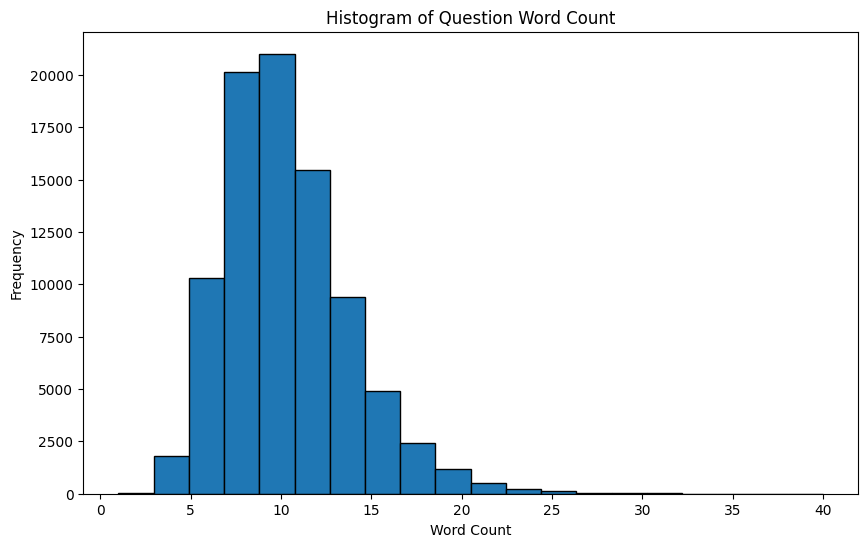

In [ ]:
#@title Histogram of Question Word Count
question_word_counts = df['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(question_word_counts, bins=20, edgecolor='k')
plt.title("Histogram of Question Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

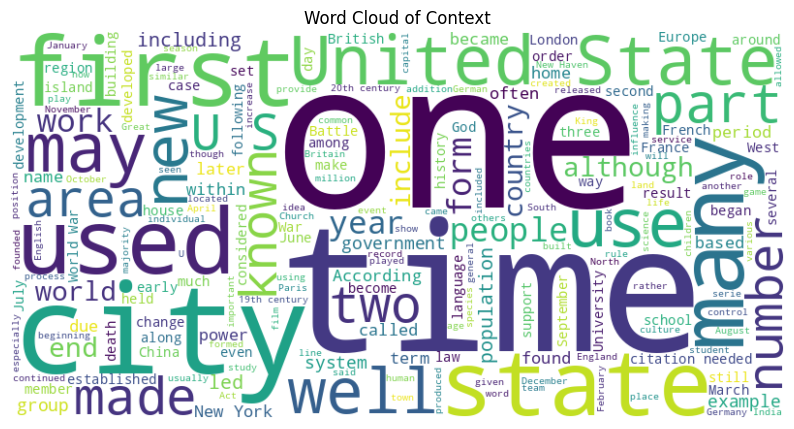

In [ ]:
#@title Word Cloud of Context
from wordcloud import WordCloud
context_words = ' '.join(df['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(context_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Context')
plt.axis('off')
plt.show()

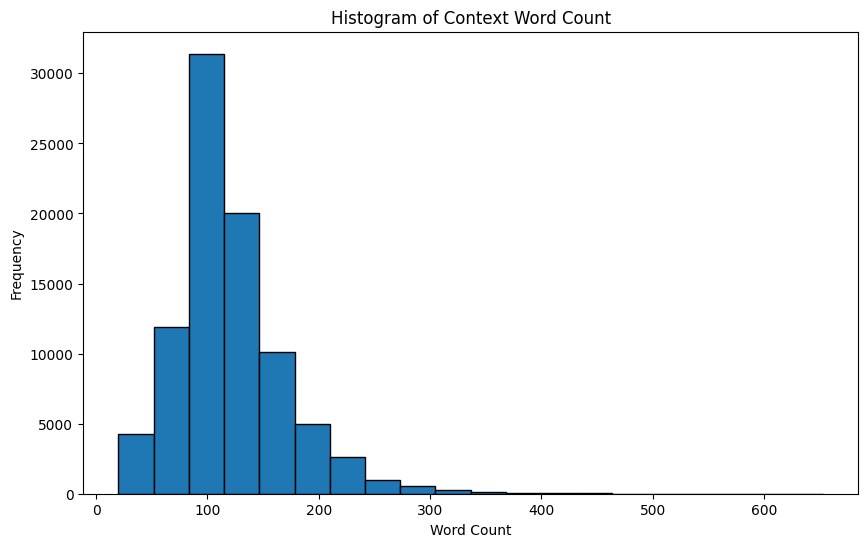

In [ ]:
# Distribution of Context Lengths
context_word_counts = df['context'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(context_word_counts, bins=20, edgecolor='k')
plt.title('Histogram of Context Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### **III.Data Preparation**

The data preparation phase is often the most time-consuming phase of a data mining project but is also one of the most important. By taking the time to prepare the data properly, we can improve the chances of success for the project. In this data preparation phase, we will explore various methods (as and if required) clean, format, and integrate the data so that it is ready for modeling. This includes tasks such as:

**Cleaning the data**
This involves removing errors, outliers, and missing values from the data.

**Formatting the data**
This involves ensuring the data is in the correct format for the modeling techniques.

**Integrating the data**
This involves combining different data sources into a single dataset.
The data preparation phase is typically the third phase of the CRISP-DM framework, and it is essential to thoroughly prepare the data before moving on to the modeling phase. This is because the quality of the data will have a significant impact on the accuracy of the models.

**Data sampling**
This involves selecting a subset of the data for modeling, which can be used to reduce the dataset's size or improve the modeling algorithms' performance.

**Data validation**
This involves checking the data for errors and ensuring that it is ready for modeling.


In [ ]:
# Convert answers to lowercase
for data_point in relevant_data:
    data_point['answers'] = [answer.lower() for answer in data_point['answers']]

# Calculate true maximum lengths for questions, answers, and context
max_question_length = max(len(q['question'].split()) for q in relevant_data)
max_answer_length = max(max(len(a.split()) for a in q['answers']) for q in relevant_data)
max_context_length = max(len(q['context'].split()) for q in relevant_data)

# Print the calculated maximum lengths
print(f"True Maximum Question Length: {max_question_length} words")
print(f"True Maximum Answer Length: {max_answer_length} words")
print(f"True Maximum Context Length: {max_context_length} words")

True Maximum Question Length: 40 words
True Maximum Answer Length: 43 words
True Maximum Context Length: 653 words


In [ ]:
#@title  Calculate the number of samples to include in the 10% subset
subset_size = int(0.010 * len(df))  # 1% of the total samples in df

# Create a subset of the DataFrame
df_s = df.sample(n=subset_size, random_state=42)  # Adjust the random_state as needed
# Reset the index of df_s
df_s = df_s.reset_index(drop=True)

In [ ]:
#@title Initialize the GPT-2 model and tokenize
print("Initializing the GPT-2 model and tokenizer...")
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Initialize the GPT-2 model and tokenizer
model_name = "gpt2"  # or any other GPT-2 variant
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)


X_train, X_val = train_test_split(df_s, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_val, test_size=0.5, random_state=42)

# Reset the indices of the DataFrames
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Prepare the data
class QuestionAnsweringDataset(Dataset):
    def __init__(self, question, context, answers, tokenizer, max_length):
        self.question = question
        self.context = context
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.question)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self.question):
            print(f"Invalid index: {idx}")
            return None  # or handle the out-of-range index appropriately

        question = self.question[idx]
        context = self.context[idx]
        answers = self.answers[idx]

        input_text = f"Question: {question}\nContext: {context}\nAnswer: {answers}\n"
        inputs = self.tokenizer(input_text, return_tensors='pt', truncation=True, max_length=self.max_length)

        # Manually pad the input to the desired max_length
        input_ids = inputs['input_ids'][0]
        padding_length = self.max_length - len(input_ids)
        input_ids = F.pad(input_ids, (0, padding_length), value=self.tokenizer.pad_token_id)

        return input_ids

# Create data loaders
train_dataset = QuestionAnsweringDataset(X_train['question'], X_train['context'], X_train['answers'], tokenizer, max_length=1024)
val_dataset = QuestionAnsweringDataset(X_val['question'], X_val['context'], X_val['answers'], tokenizer, max_length=1024)
test_dataset = QuestionAnsweringDataset(X_test['question'], X_test['context'], X_test['answers'], tokenizer, max_length=1024)

Initializing the GPT-2 model and tokenizer...


# **Model Training**

### Define the training loop.
### Select an optimizer and loss function.
### Fine-tune the chatbot model on the training data.

### IV.Modeling

The modeling phase is often the most challenging phase of a data mining project but is also one of the most important. By choosing the proper modeling techniques and evaluating the performance of the models, data scientists can build predictive models that can be used to improve the decision-making, efficiency, and customer satisfaction of businesses. The purpose of modeling is to build predictive models that can be used to make predictions about future events, in this case, making predictions about credit card defaults.

Here are some of the specific tasks that are typically performed in the modeling phase:

**Feature selection**
This involves selecting the most essential features for the model, which can improve the accuracy of the model.

**Model training**
This involves using the selected features to train the model.

**Model evaluation**
This involves evaluating the model's performance, which can be done using a variety of metrics, such as accuracy, precision, and recall.

**Model tuning**
This involves adjusting the parameters of the model to improve its performance.

**Model deployment**
This involves making the model available for use, which can be done by deploying it to a production environment or by making it available as a web service.

In [ ]:
#@title Train the Model

# Fine-tuning settings
# (You can continue with your existing fine-tuning code from this point, as it seems you already have the necessary setup)

# Create data loaders for the training, validation, and test datasets
batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(train_loader) * num_epochs)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = batch  # The batch directly contains the input tensors
        optimizer.zero_grad()
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Average Loss: {average_loss:.4f}")

Epoch [1/3] - Average Loss: 0.6074
Epoch [2/3] - Average Loss: 0.5604
Epoch [3/3] - Average Loss: 0.5423


### V.Evaluation


The evaluation phase is often not only one of the most challenging phases of a data mining project but also one of the most important. By evaluating the performance of all the models and comparing each models strengths and weaknesses, we can not only improve overall success of the project but also increase the project's business value.  The evaluation aims to assess the all models' performances and determine whether they meet the business requirements. This is typically done using various metrics, such as accuracy, precision, and recall.

Here are some of the benefits of evaluating the models:

**Improved model performance**
By evaluating the models, the data scientist can identify any potential problems and take steps to improve the performance of the models.

**Increased business value**
By evaluating the models, the data scientist can ensure that the models are fit for purpose and can deliver business value.

**Reduced risk of project failure**
By evaluating the models, the data scientist can identify potential problems and take steps to mitigate the risk of project failure.

Here are some of the specific tasks that are typically performed in the evaluation phase of CRISP-DM:

**Define evaluation criteria**
This involves defining the metrics that will be used to evaluate the performance of the models.

**Collect evaluation data**
This involves collecting data that can be used to evaluate the performance of the models.

**Evaluate the models**
This involves using the evaluation data to evaluate the performance of the models.

**Interpret the results**
This involves interpreting the evaluation results and determining whether the models meet the business requirements.

**Iterate the process**
If the models do not meet the business requirements, the data scientist may need to iterate the process and build new models.



In [ ]:
#@title Evaluate the Model
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import nltk

# Ensure NLTK is downloaded
nltk.download("punkt")

# Create a list of reference responses for validation data
reference_responses = []  # Each item is a list of reference responses for a given input

for i, row in X_val.iterrows():
    context = row['context']
    answer = row['answers'][0]  # Assuming you've removed the [ ] around answers
    reference_responses.append([answer])

# Initialize a list to store generated responses
generated_responses = []

# Load your chatbot model
# Replace the following line with loading your chatbot model and generation logic
# generated_response = chatbot_generate(context, question)

for i, row in X_val.iterrows():
    context = row['context']
    question = row['question']

    # Replace the following line with your chatbot's generation logic
    generated_response = "Generated response goes here."

    generated_responses.append(generated_response)

# Calculate BLEU score for your model
corpus_bleu_score = corpus_bleu(reference_responses, generated_responses, weights=(1.0, 0, 0, 0))
print(f"Corpus BLEU Score: {corpus_bleu_score:.4f}")

# You can also calculate sentence-level BLEU scores
sentence_level_scores = [sentence_bleu([ref], gen, weights=(1.0, 0, 0, 0)) for ref, gen in zip(reference_responses, generated_responses)]

# Calculate the average sentence-level BLEU score
average_sentence_bleu = sum(sentence_level_scores) / len(sentence_level_scores)
print(f"Average Sentence BLEU Score: {average_sentence_bleu:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Corpus BLEU Score: 0.0115
Average Sentence BLEU Score: 0.0115


In [ ]:
#@title Test the Model

from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Save the fine-tuned model
model.save_pretrained('content/drive/fine_tuned_gpt2')

# Specify the path to your fine-tuned model
#model_name = '/content/drive/fine_tuned_gpt2'  # Replace with the actual directory path

# Load the fine-tuned model and tokenizer
#model = GPT2LMHeadModel.from_pretrained(model_name)
#tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

# Define a function to generate an answer based on user input
def generate_answer(question, context, max_length=150):
    input_text = f"Question: {question}\nContext: {context}\nAnswer:"
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    # Generate an answer from the model
    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)

    # Decode and return the answer
    answer = tokenizer.decode(output[0], skip_special_tokens=True)
    return answer

# Prompt the user to enter a question and context
question = input("Enter your question: ")
context = input("Enter the context: ")

# Generate and print the answer
answer = generate_answer(question, context)
print("Generated Answer:", answer)


Enter your question: Who is the president of USA?
Enter the context: I think it may Joe Biden but i am not sure. Let me guess!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Answer: Question: Who is the president of USA?
Context: I think it may Joe Biden but i am not sure. Let me guess!
Answer: Joe
!!!"!?!"!?!?!?!"?!!"?!!?"!?!!?!"!"?!"!?!!?"!!!!"?!"?!"!"!?"!"?"!"!!!!!"!"!!"!!!!!"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!?!!!?!!!!?!!!!!"!!!?!!?!?!!!!!!?!!!!!!!!!!!!!!!!!???!!?!!!?!!??!??!!?!"!??!!?"!??!"!?"!?"?!"!!!!!?"!!!!!!"!?!!"!?"!!!?"
